In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
def generate_data(N=1000, seed=0, effect=1):
    rng = np.random.default_rng(seed)
    
    a = rng.binomial(1, 0.5, size=N)
    X = rng.normal(0, 1, size=(N, 2))
    X[a==1, 1] += 1  # x1 has larger discrepancy between treated and control
    y = X[:, 0] + X[:, 1] + effect*a
    
    X = pd.DataFrame(X, columns=["x_smallASMD", "x_bigASMD"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

In [3]:
def calculate_asmd(X, a):
    is_treated = a == 1
    X1 = X.loc[is_treated]
    X0 = X.loc[~is_treated]
    smds = (X0.mean() - X1.mean()) / np.sqrt(X0.var() + X1.var())
    asmds = smds.abs()
    return asmds

In [4]:
X, a, y = generate_data()
data = X.join(a).join(y)

In [5]:
calculate_asmd(X, a)

x_smallASMD    0.031651
x_bigASMD      0.686306
dtype: float64

In [6]:
print(sm.formula.ols("y ~ x_smallASMD + x_bigASMD + a", data=data).fit().params["a"])

1.0000000000000004


In [7]:
print(sm.formula.ols("y ~ a", data=data).fit().params["a"])

1.935770089805863


In [8]:
print(sm.formula.ols("y ~ x_smallASMD + a", data=data).fit().params["a"])

1.9811291769803336


In [9]:
print(sm.formula.ols("y ~ x_bigASMD + a", data=data).fit().params["a"])

0.9375093250503619


In [10]:
print("Adjusting for both covariates retreives the true effect:")
print(sm.formula.ols("y ~ x_smallASMD + x_bigASMD + a", data=data).fit().params["a"])
print()
print("Adjusting for the covariate with the larger ASMD leads to relatively similar treatment effect:")
print(sm.formula.ols("y ~ x_bigASMD + a", data=data).fit().params["a"])
print()
print("But adjusting for the covaraite with the smaller ASMD leads to a far more biased treatement effect:")
print(sm.formula.ols("y ~ x_smallASMD + a", data=data).fit().params["a"])

Adjusting for both covariates retreives the true effect:
1.0000000000000004

Adjusting for the covariate with the larger ASMD leads to relatively similar treatment effect:
0.9375093250503619

But adjusting for the covaraite with the smaller ASMD leads to a far more biased treatement effect:
1.9811291769803336


## Plot the results

In [11]:
import seaborn.objects as so
import matplotlib.pyplot as plt

In [12]:
no_adjustment = sm.formula.ols("y ~ a", data=data).fit()
full_adjustment = sm.formula.ols("y ~ x_smallASMD + x_bigASMD + a", data=data).fit()
adjusting_big = sm.formula.ols("y ~ + x_bigASMD + a", data=data).fit()
adjusting_small = sm.formula.ols("y ~ x_smallASMD + a", data=data).fit()

In [13]:
res = [
    ["No adjustment", no_adjustment.params["a"], 
     no_adjustment.conf_int(0.05).loc["a", 0], no_adjustment.conf_int(0.05).loc["a", 1]],
    ["Adjusting for\nsmall imbalanced", adjusting_small.params["a"], 
     adjusting_small.conf_int(0.05).loc["a", 0], adjusting_small.conf_int(0.05).loc["a", 1]],
    ["Adjusting for\nhigh imbalanced", adjusting_big.params["a"], 
     adjusting_big.conf_int(0.05).loc["a", 0], adjusting_big.conf_int(0.05).loc["a", 1]],
    ["Full adjustment", full_adjustment.params["a"], 
     full_adjustment.conf_int(0.05).loc["a", 0], full_adjustment.conf_int(0.05).loc["a", 1]],
]
res = pd.DataFrame(
    res, 
    columns=["model", "effect", "ci_lower", "ci_upper"],
)
res

,model,effect,ci_lower,ci_upper
0,No adjustment,1.935770,1.757893,2.113647
1,Adjusting for\nsmall imbalanced,1.981129,1.855418,2.106840
2,Adjusting for\nhigh imbalanced,0.937509,0.800115,1.074903
3,Full adjustment,1.000000,1.000000,1.000000


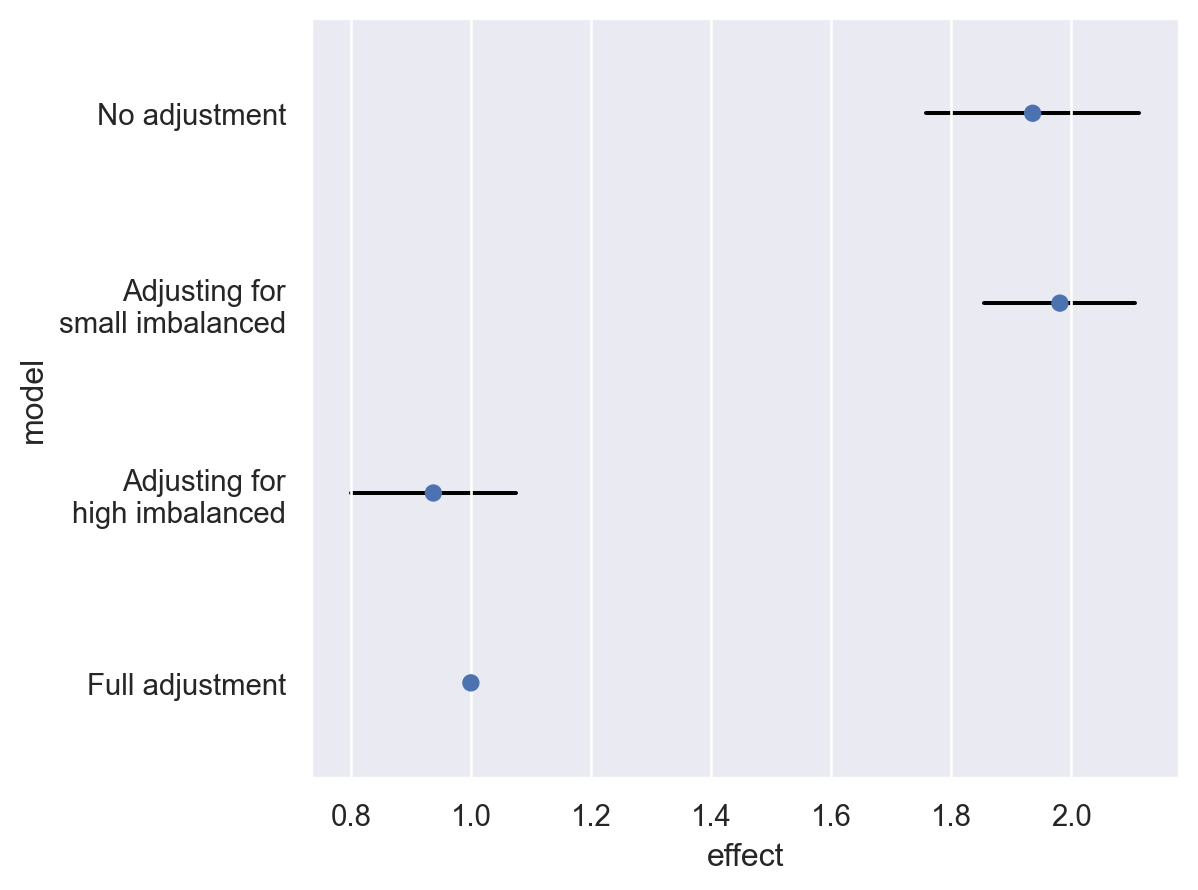

In [14]:
p = so.Plot(
    res,
    x="effect",
    y="model",
    xmin="ci_lower",
    xmax="ci_upper",
).add(
    so.Dot()
).add(
    so.Range(color="black", artist_kws={"zorder":0, "capstyle": "round"})
)

p    

In [15]:
res["ci_minus"] = res["effect"] - res["ci_lower"]
res["ci_plus"] = res["ci_upper"] - res["effect"]
res = res.iloc[::-1]

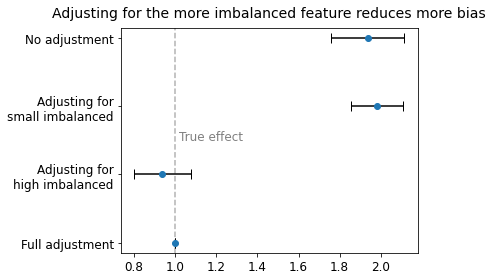

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(
    x=res["effect"],
    y=res["model"],
    xerr=res[["ci_minus", "ci_plus"]].T,
    capsize=5,
    ecolor="black",
    marker=".",
    markersize=12,
    linestyle="none",
)
ax.axvline(1, linestyle="--", color="0.7", zorder=0)
# ax.text(1+0, 0-0.6, "True effect", color="0.5", fontsize=12, ha="center")
# ax.text(1+0, 3+0.2, "True effect", color="0.5", fontsize=12, ha="center")
ax.text(1+0.02, 1+0.5, "True effect", color="0.5", fontsize=12)
ax.set_title(
    "Adjusting for the more imbalanced feature reduces more bias", 
    # ha="right",
    fontsize=14,
    y=1.02
)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()

In [17]:
# fig.savefig("figures\\asmd_adjustment.png", facecolor="white", bbox_inches = "tight")
# fig.savefig("figures\\asmd_adjustment.pdf", bbox_inches = "tight")
# fig.savefig("figures\\asmd_adjustment.svg")

Now with different $Xy$ coefficients

In [18]:
def generate_data(N=1000, seed=0, effect=1):
    rng = np.random.default_rng(seed)
    
    a = rng.binomial(1, 0.5, size=N)
    X = rng.normal(0, 1, size=(N, 2))
    X[a==1, 1] += 2  # x1 has larger discrepancy between treated and control
    y = X[:, 0] + 0.001*X[:, 1] + effect*a
    
    X = pd.DataFrame(X, columns=["x_smallbias", "x_bigbias"])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    data = X.join(a).join(y)
    return data, X, a, y


In [19]:
data, X, a, y = generate_data(effect=0)

In [20]:
calculate_asmd(X, a)

x_smallbias    0.031651
x_bigbias      1.386414
dtype: float64

In [21]:
print("True\t", round(sm.formula.ols("y ~ x_smallbias + x_bigbias + a", data=data).fit().params["a"], 3))
print("Small\t", round(sm.formula.ols("y ~ x_smallbias + a", data=data).fit().params["a"], 3))
print("Big\t", round(abs(sm.formula.ols("y ~ x_bigbias + a", data=data).fit().params["a"]), 3))

True	 0.0
Small	 0.002
Big	 0.081
